In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, neighbors, ensemble, svm, metrics
from imblearn.under_sampling import CondensedNearestNeighbour 

### Составляем различные таблицы

In [2]:
dau = pd.read_csv('practice_dau_and.csv', sep='|')
pact = pd.read_csv('practice_pact_and.csv', sep='|')
print('Loaded')

Loaded


In [17]:
pay_players = pact[pact.transactions > 0].reset_index()
pay_players = pay_players.drop(['index'], axis='columns')
#print(pay_players)
pay_players.to_csv('pay_players_pact.csv', sep='|')
pay_players = pay_players.groupby(['id'], as_index=False).count()
pay_players = pay_players.drop(['actdate', 'regdate', 'clusters', 
                                'revenue', 'transactions', 'quest',
                                'm_quests', 'crystals', 'store_enters'], axis='columns')
print(pay_players)
pay_players.to_csv('pay_players.csv')

               id
0      0001c0d9c5
1      000249ee3b
2      0004bbc378
3      000bc5be57
4      00137c70eb
5      001501221a
6      001566c949
7      0016ec0270
8      001bdcf118
9      001dcb349d
10     001e86bb74
11     001f6f6bda
12     00217a789a
13     00240222ee
14     002adc591b
15     002d410bd3
16     002f2521f5
17     0030797a91
18     0030b81513
19     0032eb2d55
20     00332e58de
21     003544c4ea
22     003717dd8c
23     00371a21a9
24     00380b3464
25     003b4acbbd
26     003c981696
27     003d74cb8d
28     003e1afdab
29     003e67dd8a
...           ...
30391  ffb16a1c26
30392  ffb3c42867
30393  ffb5376eee
30394  ffb71a2641
30395  ffbbd7823a
30396  ffbd959b77
30397  ffbff6e3b0
30398  ffc1670161
30399  ffc286fc79
30400  ffc638b435
30401  ffc7cc6362
30402  ffca076aee
30403  ffd59fa03d
30404  ffd5a29fa9
30405  ffdc226141
30406  ffdd5e88b8
30407  ffdf621be9
30408  ffe0ac456f
30409  ffe5094796
30410  ffe5227876
30411  ffe8349510
30412  ffea788845
30413  ffeba687e9
30414  ffe

In [20]:
dau2 = pd.merge(pay_players, dau, on=['id'], how='left')

In [103]:
print(dau)
print(dau2)

In [22]:
dau2.to_csv('pay_players_dau.csv')

In [24]:
dau_pact = pd.merge(dau2, pact, on=['id', 'actdate'], how='left')

In [26]:
print(dau_pact)
dau_pact.to_csv('pay_players_dau_pact.csv')

                id country  pgr     actdate     regdate  clusters  revenue  \
0       0001c0d9c5      RU    7  2017-01-28         NaN       NaN      NaN   
1       0001c0d9c5      RU   23  2017-01-30  2017-01-24      19.0     0.00   
2       0001c0d9c5      RU  219  2017-01-24  2017-01-24      13.0  4237.98   
3       0001c0d9c5      RU  164  2017-01-26  2017-01-24      18.0     0.00   
4       0001c0d9c5      RU  169  2017-01-25  2017-01-24      17.0  5922.96   
5       0001c0d9c5      RU   68  2017-01-29  2017-01-24      19.0  2118.99   
6       0001c0d9c5      RU    6  2017-03-01  2017-03-01      -2.0     0.00   
7       000249ee3b      US    2  2017-04-17         NaN       NaN      NaN   
8       000249ee3b      US   84  2017-04-13  2017-04-11       8.0     0.00   
9       000249ee3b      US   67  2017-04-16  2017-04-11       9.0     0.00   
10      000249ee3b      US  227  2017-04-11  2017-04-11       5.0     0.00   
11      000249ee3b      US   96  2017-04-12  2017-04-11       5.

In [65]:
dau2 = pd.read_csv('pay_players_dau.csv', parse_dates=True).drop('Unnamed: 0', axis='columns')

In [27]:
dau_pact = dau_pact.set_index('actdate', drop=False).sort_index(0)

### График, показывающий активность игрока

In [19]:
def show_player_pgr(player_id, days=31):
    player_table = pd.DataFrame({'id': [player_id]})
    res = pd.merge(player_table, dau_pact, on=['id'], how='left')
    #print(res)
    res = res.drop(['crystals', 'store_enters', 'm_quests', 'quest', 
                    'revenue', 'transactions', 'country', 'clusters'], axis='columns')
    res = res.groupby(['actdate'], as_index=False).sum()
    res = res.set_index('actdate')
    res = res.sort_index(0)
    res = res.reset_index()
    #print(res)
    first_day = res['actdate'][0]
    m_later_day = pd.date_range(first_day, periods=days, freq='D').date[-1]
    #print(first_day, str(m_later_day))
    new_sample_df = res.set_index('actdate').loc[first_day:str(m_later_day)]
    new_sample_df.plot()
    plt.show()

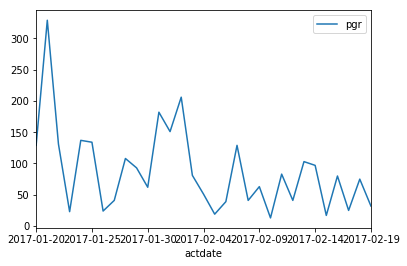

In [20]:
show_player_pgr('0004bbc378')

### Сводная таблица

In [96]:
dau_pact = pd.read_csv('pay_players_dau_pact.csv').drop('Unnamed: 0', axis='columns')
dau_pact_table = dau_pact.drop(['clusters', 'revenue', 'quest', 
                          'm_quests', 'crystals', 'store_enters', 
                          'transactions', 'country'], axis='columns')

In [97]:
dau_pact_table['day_n'] = (pd.to_datetime(dau_pact_table['actdate']) - 
                           pd.to_datetime(dau_pact_table['regdate'])).dt.days
dau_pact_table = dau_pact_table[dau_pact_table.day_n < 31 + 14].reset_index()
dau_pact_table = dau_pact_table[pd.to_datetime(dau_pact_table.regdate) < pd.to_datetime('2017-04-15')].reset_index()
dau_pact_table = dau_pact_table.pivot_table(values='pgr', columns=['day_n'], index=['id'], aggfunc='sum')

In [67]:
print(dau_pact_table)

               0.0     1.0     2.0     3.0     4.0     5.0     6.0     7.0  \
id                                                                           
0001c0d9c5   225.0   169.0   164.0     NaN     NaN    68.0    23.0     NaN   
000249ee3b   227.0    96.0   142.0     NaN     NaN    67.0     NaN     NaN   
0004bbc378   129.0   329.0   131.0     NaN   137.0   134.0    24.0    41.0   
000bc5be57   413.0    81.0   233.0   123.0    92.0    45.0    79.0     NaN   
00137c70eb   550.0    70.0     NaN   180.0     NaN   286.0   230.0   191.0   
001566c949   229.0    42.0   124.0     NaN     NaN     NaN    98.0   230.0   
0016ec0270   416.0   221.0     NaN    93.0    19.0     NaN    45.0   165.0   
001bdcf118   260.0    15.0     NaN     NaN    47.0   162.0   147.0     NaN   
001dcb349d   180.0   339.0    91.0    64.0     NaN    96.0    51.0     NaN   
001e86bb74    55.0    59.0    34.0    73.0    56.0     NaN   142.0    55.0   
001f6f6bda   173.0   478.0    25.0    15.0     NaN   148.0    86

In [5]:
dau_pact_table.to_csv('dau_pact_table.csv')

### Различные признаки

In [21]:
dau_pact_table['m_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9, 
                      10, 11, 12, 13, 14, 15, 16,
                      17, 18, 19, 20, 21, 22, 23, 
                      24, 25, 26, 27, 28, 29, 30]].count(1)
dau_pact_table['w1_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].count(1)
dau_pact_table['w2_played'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].count(1)
dau_pact_table['w3_played'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].count(1)
dau_pact_table['w4_played'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].count(1)
dau_pact_table['w1_max'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
dau_pact_table['w2_max'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
dau_pact_table['w3_max'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
dau_pact_table['w4_max'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
dau_pact_table['w1_mean'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
dau_pact_table['w2_mean'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
dau_pact_table['w3_mean'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
dau_pact_table['w4_mean'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
dau_pact_table['w1_meandmax'] = (dau_pact_table['w1_mean'] / dau_pact_table['w1_max']).replace('NaN', 0)
dau_pact_table['w2_meandmax'] = (dau_pact_table['w2_mean'] / dau_pact_table['w2_max']).replace('NaN', 0)
dau_pact_table['w3_meandmax'] = (dau_pact_table['w3_mean'] / dau_pact_table['w3_max']).replace('NaN', 0)
dau_pact_table['w4_meandmax'] = (dau_pact_table['w4_mean'] / dau_pact_table['w4_max']).replace('NaN', 0)
dau_pact_table['result_played'] = dau_pact_table[[31.0, 32, 33, 34, 35, 36, 37,
                                                  38, 39, 40, 41, 42, 43, 44]].count(1)
dau_pact_table['is_active'] = (dau_pact_table['result_played'] > 1) * 1
dau_pact_table['result_category'] = (dau_pact_table['result_played'] / 4).round()
#dau_pact_table['result_intensity'] = dau_pact_table[[31.0, 32, 33, 34, 35, 36, 37,
#                                                  38, 39, 40, 41, 42, 43, 44]].replace('NaN', 0).mean(1)
print(dau_pact_table)

               id     0.0     1.0     2.0     3.0     4.0     5.0     6.0  \
0      0001c0d9c5   225.0   169.0   164.0     NaN     NaN    68.0    23.0   
1      000249ee3b   227.0    96.0   142.0     NaN     NaN    67.0     NaN   
2      0004bbc378   129.0   329.0   131.0     NaN   137.0   134.0    24.0   
3      000bc5be57   413.0    81.0   233.0   123.0    92.0    45.0    79.0   
4      00137c70eb   550.0    70.0     NaN   180.0     NaN   286.0   230.0   
5      001566c949   229.0    42.0   124.0     NaN     NaN     NaN    98.0   
6      0016ec0270   416.0   221.0     NaN    93.0    19.0     NaN    45.0   
7      001bdcf118   260.0    15.0     NaN     NaN    47.0   162.0   147.0   
8      001dcb349d   180.0   339.0    91.0    64.0     NaN    96.0    51.0   
9      001e86bb74    55.0    59.0    34.0    73.0    56.0     NaN   142.0   
10     001f6f6bda   173.0   478.0    25.0    15.0     NaN   148.0    86.0   
11     00217a789a   123.0     7.0    56.0     NaN     8.0     NaN     NaN   

### Регрессия:

In [111]:
#clf_features = ['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                 'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax',
#                 'w1_mean', 'w2_mean', 'w3_mean', 'w4_mean',
#                 'clusters_w1_mean', 'clusters_w2_mean', 'clusters_w3_mean', 'clusters_w4_mean']#,
#                'quest_w1_mean',
#              'quest_w2_mean',        'quest_w3_mean',        'quest_w4_mean',
#           'm_quests_w1_mean',     'm_quests_w2_mean',     'm_quests_w3_mean',
#           'm_quests_w4_mean',     'crystals_w1_mean',     'crystals_w2_mean',
#           'crystals_w3_mean',     'crystals_w4_mean', 'transactions_w1_mean',
#       'transactions_w2_mean', 'transactions_w3_mean', 'transactions_w4_mean']

dau_pact_table = dau_pact_table.fillna(0)
for col in clf_features:
    dau_pact_table[col] = dau_pact_table[col].round(3)
#print(dau_pact_table)

train_input_clf = dau_pact_table[:16000].as_matrix(columns=clf_features)
train_output_clf = np.array(dau_pact_table['is_active'][:16000].tolist())

#cnn = CondensedNearestNeighbour(random_state=42) 
#train_input_clf, train_output_clf = cnn.fit_sample(train_input_clf, train_output_clf)

#fitted_clf = linear_model.SGDClassifier(loss='log', epsilon=0.01, n_iter=4).fit(train_input_clf, train_output_clf)
#dau_pact_table['predict_active'] = fitted_clf.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                        'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])).round()

#fitted_clf = linear_model.SGDRegressor(epsilon=0.01).fit(train_input_clf, train_output_clf)
#dau_pact_table['predict_active'] = fitted_clf.predict(dau_pact_table.as_matrix(columns=clf_features)).round()

#fitted_clf_rfr = ensemble.RandomForestRegressor(n_estimators=30).fit(train_input_clf, train_output_clf)
#dau_pact_table['predict_active'] = fitted_clf_rfr.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                        'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])).round()


fitted_clf_gbr = ensemble.GradientBoostingRegressor(subsample=0.7, loss='ls').fit(train_input_clf, train_output_clf)
dau_pact_table['predict_active'] = fitted_clf_gbr.predict(dau_pact_table.as_matrix(
                                                            columns=clf_features)).round()

#fitted_clf_etr = ensemble.ExtraTreesRegressor(n_estimators=20).fit(train_input_clf, train_output_clf)
#dau_pact_table['predict_active'] = fitted_clf_etr.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                        'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])).round()

#fitted_clf_svc = svm.SVC().fit(train_input_clf, train_output_clf)
#dau_pact_table['predict_active'] = fitted_clf_svc.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                        'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])).round()


#fitted_clf_knr = neighbors.KNeighborsRegressor().fit(train_input_clf, train_output_clf)
#dau_pact_table['predict_active'] = fitted_clf_knr.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                            'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])).round()

train_input_prd = dau_pact_table[:16000][dau_pact_table['is_active'] == 1].as_matrix(columns=clf_features)
train_output_prd = np.array(dau_pact_table[:16000][dau_pact_table['is_active'] == 1]['result_played'].tolist())

#train_input_prd, train_output_prd = cnn.fit_sample(train_input_prd, train_output_prd)
#fitted_prd = linear_model.SGDRegressor(epsilon=0.01).fit(train_input_prd, train_output_prd)
#dau_pact_table['predict_days'] = fitted_prd.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                      'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])) * dau_pact_table['predict_active']

#fitted_prd_rfr = ensemble.RandomForestRegressor().fit(train_input_prd, train_output_prd)
#dau_pact_table['predict_days'] = fitted_prd_rfr.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                      'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])) * dau_pact_table['predict_active']

fitted_prd_etr = ensemble.ExtraTreesRegressor(n_estimators=100).fit(train_input_prd, train_output_prd)
dau_pact_table['predict_days'] = fitted_prd_etr.predict(dau_pact_table.as_matrix(columns=clf_features))

#fitted_prd_bgr = ensemble.GradientBoostingRegressor(subsample=0.6, loss='ls').fit(train_input_prd, train_output_prd)
#dau_pact_table['predict_days'] = fitted_prd_bgr.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                      'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])) * dau_pact_table['predict_active']

#fitted_prd_knr = neighbors.KNeighborsRegressor(10).fit(train_input_prd, train_output_prd)
#dau_pact_table['predict_days'] = fitted_prd_knr.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                      'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])) * dau_pact_table['predict_active']

#train_input_cat = dau_pact_table[:16000].as_matrix(columns=clf_features)
#train_output_cat = np.array(dau_pact_table['result_category'][:16000].tolist())

#fitted_cat_prd_knr = neighbors.KNeighborsRegressor(10).fit(train_input_cat, train_output_cat)
#dau_pact_table['predict_category'] = fitted_cat_prd_knr.predict(dau_pact_table.as_matrix(columns=clf_features)).round()


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### Попытки предсказаний, точность

In [112]:
#dau_pact_table['predict_intensity'] = (dau_pact_table['w1_mean'] * 0.2 
#                                       + dau_pact_table['w2_mean'] * 0.3 
#                                       + dau_pact_table['w3_mean'] * 0.5
#                                       + dau_pact_table['w4_mean'] * 1)
#dau_pact_table['intensity_acc'] = ((dau_pact_table['result_intensity'] - dau_pact_table['predict_intensity']).abs()
#                                   / (dau_pact_table['result_intensity']))
#dau_pact_table['predict_played'] = (dau_pact_table['w1_played'] * 0.2
#                                    + dau_pact_table['w2_played'] * 0.3
#                                    + dau_pact_table['w3_played'] * 0.5
#                                    + dau_pact_table['w4_played'] * 1).round()
#dau_pact_table['played_acc'] = ((dau_pact_table['result_played'] - dau_pact_table['predict_played']).abs()
#                                / (dau_pact_table['result_played']))
dau_pact_table['clf_acc'] = (dau_pact_table['is_active'] == dau_pact_table['predict_active']) * 1
dau_pact_table['clf_e1'] = (dau_pact_table['is_active'] > dau_pact_table['predict_active']) * 1
dau_pact_table['clf_e2'] = (dau_pact_table['is_active'] < dau_pact_table['predict_active']) * 1
#dau_pact_table['prd_acc'] = ((dau_pact_table['result_played'] - dau_pact_table['predict_days']).abs()
#                                / (dau_pact_table['result_played']))
dau_pact_table['prd_delta'] = ((dau_pact_table['result_played'] - dau_pact_table['predict_days']).abs())
dau_pact_table['overall_delta'] = ((dau_pact_table['result_played'] * dau_pact_table['is_active'] - dau_pact_table['predict_days'] * dau_pact_table['predict_active']).abs())
#dau_pact_table['category_delta'] = ((dau_pact_table['result_category'] - dau_pact_table['predict_category'])).abs()
#print(dau_pact_table)
#dau_pact_table = dau_pact_table.set_index('id')

Среднее отклонение классификатора активности: 0.10624516628
Ошибка классификатора 1 рода (игрок на самом деле активен): 0.063901778809
Ошибка классификатора 2 рода (игрок на самом деле неактивен): 0.042343387471
Среднее отклонение предсказателя дней: 2.6575764072
Среднее общее отклонение: 1.15037412993
[8938, 1641, 530, 122]
[2303, 1346, 359, 78]


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


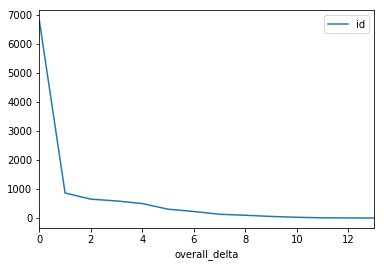

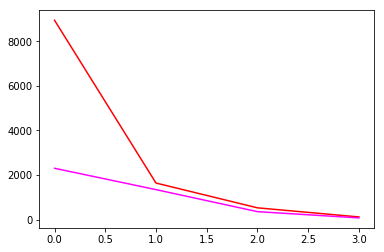

In [113]:
#num_inf = 0
#sum_infs = 0
#sum_v = 0
#num_v = 0
#nans = 0
prd_delta = dau_pact_table[16000:][dau_pact_table['is_active'] == 1]['prd_delta'].mean()
clf_delta = 1 - dau_pact_table['clf_acc'][16000:].mean()
clf_e1 = dau_pact_table['clf_e1'][16000:].mean()
clf_e2 = dau_pact_table['clf_e2'][16000:].mean()
overall_delta = dau_pact_table['overall_delta'][16000:].mean()
#category_delta = dau_pact_table['category_delta'][16000:].mean()
#for i in range(0, 26435):
#    #print(dau_pact_table['played_acc'][i])
#    if np.isnan(dau_pact_table['regr_acc'][i]):
#        nans += 1
#    elif not np.isfinite(dau_pact_table['regr_acc'][i]):
#        sum_infs += dau_pact_table['regr_predict_played'][i]
#        num_inf += 1
#    else:
#        sum_v += dau_pact_table['regr_acc'][i]
#        num_v += 1
#print("Среднее процентное отклонение (не inf):", sum_v / num_v * 100, '%')
#print("Среднее отклонение для acc=inf (дни): ", sum_infs / num_inf)
#print("Среднее отклонение (дни):", delta)
print('Среднее отклонение классификатора активности:', clf_delta)
print('Ошибка классификатора 1 рода (игрок на самом деле активен):', clf_e1)
print('Ошибка классификатора 2 рода (игрок на самом деле неактивен):', clf_e2)
print('Среднее отклонение предсказателя дней:', prd_delta)
print('Среднее общее отклонение:', overall_delta)
#print('Среднее отклонение категории:', category_delta)
overall_delta_round = dau_pact_table['overall_delta'][16000:].round().reset_index().pivot_table(values=['id'], index=['overall_delta'], aggfunc='count')
active_delta_round = dau_pact_table[16000:][dau_pact_table['is_active'] == 1.0]['overall_delta'].round().reset_index().pivot_table(values=['id'], index=['overall_delta'], aggfunc='count')
overall_delta_round.plot()
#print(overall_delta_round)
#print(active_delta_round)
categories_delta = [int(overall_delta_round[0:3].sum()), int(overall_delta_round[3:6].sum()), int(overall_delta_round[6:9].sum()), int(overall_delta_round[9:14].sum())]
active_categories_delta = [int(active_delta_round[0:3].sum()), int(active_delta_round[3:6].sum()), int(active_delta_round[6:9].sum()), int(active_delta_round[9:14].sum())]
print(categories_delta)
print(active_categories_delta)
plt.show()
plt.plot(categories_delta, color='red')
plt.plot(active_categories_delta, color='magenta')
plt.show()

In [65]:
print(fitted_clf_gbr.feature_importances_)
print(fitted_prd_etr.feature_importances_)

[  7.82790804e-03   1.09302939e-02   1.71182657e-02   4.85212562e-03
   1.97905073e-02   1.43959832e-02   7.51316065e-03   6.33078512e-03
   1.16700015e-02   8.88611283e-03   9.07207337e-03   7.30944957e-03
   1.16442975e-02   1.22255893e-02   1.01403866e-02   1.56689306e-02
   1.70176515e-02   1.29230537e-03   1.51271231e-02   2.37344681e-02
   4.95349658e-03   2.06143738e-02   1.79863702e-02   2.03780759e-02
   2.51652438e-02   3.23365960e-02   6.17704395e-02   8.20228368e-02
   1.27830359e-02   1.61016286e-03   5.06803680e-03   4.27980996e-03
   1.76386402e-02   1.63553455e-02   6.72616637e-03   2.57384535e-03
   3.06065079e-03   8.17436479e-03   1.11300810e-02   5.02642771e-03
   2.84928010e-03   1.49315317e-03   9.91733885e-03   0.00000000e+00
   1.38048937e-04   4.23630251e-04   2.04776358e-03   1.43774116e-02
   5.28552707e-03   2.37912232e-05   6.32750696e-04   0.00000000e+00
   5.14405708e-03   2.22880781e-02   5.24776429e-03   7.52676598e-03
   4.18508388e-03   5.45271005e-03

In [98]:
dau_pact_features = pd.read_csv('pay_players_dau_pact.csv').drop('Unnamed: 0', axis='columns')
features = ['pgr', 'clusters', 'quest', 'm_quests', 'transactions']
dau_pact_features['day_n'] = (pd.to_datetime(dau_pact_features['actdate']) - 
                           pd.to_datetime(dau_pact_features['regdate'])).dt.days
dau_pact_features = dau_pact_features[dau_pact_features.day_n < 31 + 14]
dau_pact_features = dau_pact_features[pd.to_datetime(dau_pact_features.regdate) < pd.to_datetime('2017-04-15')]
pay_players = pd.read_csv('pay_players.csv').drop('Unnamed: 0', axis='columns')
feature_table = pd.DataFrame(pay_players)
clf_features = []
#print(feature_table)
for feat in features:
    dau_pact_features_tmp = dau_pact_features.pivot_table(values=feat, columns=['day_n'], index=['id'], aggfunc='sum')
    dau_pact_features_tmp[feat+'_w1_mean'] = dau_pact_features_tmp[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w2_mean'] = dau_pact_features_tmp[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w3_mean'] = dau_pact_features_tmp[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w4_mean'] = dau_pact_features_tmp[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w1_max'] = dau_pact_features_tmp[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w2_max'] = dau_pact_features_tmp[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w3_max'] = dau_pact_features_tmp[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w4_max'] = dau_pact_features_tmp[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
    dau_pact_features_tmp[feat+'_w1_meandmax'] = (dau_pact_features_tmp[feat+'_w1_mean'] / dau_pact_features_tmp[feat+'_w1_max']).replace('NaN', 0)
    dau_pact_features_tmp[feat+'_w2_meandmax'] = (dau_pact_features_tmp[feat+'_w2_mean'] / dau_pact_features_tmp[feat+'_w2_max']).replace('NaN', 0)
    dau_pact_features_tmp[feat+'_w3_meandmax'] = (dau_pact_features_tmp[feat+'_w3_mean'] / dau_pact_features_tmp[feat+'_w3_max']).replace('NaN', 0)
    dau_pact_features_tmp[feat+'_w4_meandmax'] = (dau_pact_features_tmp[feat+'_w4_mean'] / dau_pact_features_tmp[feat+'_w4_max']).replace('NaN', 0)
    #for col in dau_pact_features_tmp.columns[:-4]:
    #    if col >= 3.0 and col <= 30.0:
    #        clf_features.append(feat+'_'+str(col))
    #    dau_pact_features_tmp.rename(columns={col: feat+'_'+str(col)}, inplace=True)
    dau_pact_features_tmp = dau_pact_features_tmp.reset_index()
    #print(dau_pact_features_tmp[feat+'_w1_mean'])
    
    #print(pd.DataFrame({'id': dau_pact_features_tmp['id'],
    #                                                      feat+'_w1_mean': dau_pact_features_tmp[feat+'_w1_mean'],
    #                                                      feat+'_w2_mean': dau_pact_features_tmp[feat+'_w2_mean'],
    #                                                      feat+'_w3_mean': dau_pact_features_tmp[feat+'_w3_mean'],
    #                                                      feat+'_w4_mean': dau_pact_features_tmp[feat+'_w4_mean']}))
    #print(feature_table)
    feature_table = pd.merge(feature_table, pd.DataFrame({'id': dau_pact_features_tmp['id'],
                                                          feat+'_w1_mean': dau_pact_features_tmp[feat+'_w1_mean'],
                                                          feat+'_w2_mean': dau_pact_features_tmp[feat+'_w2_mean'],
                                                          feat+'_w3_mean': dau_pact_features_tmp[feat+'_w3_mean'],
                                                          feat+'_w4_mean': dau_pact_features_tmp[feat+'_w4_mean'],
                                                          feat+'_w1_max': dau_pact_features_tmp[feat+'_w1_max'],
                                                          feat+'_w2_max': dau_pact_features_tmp[feat+'_w2_max'],
                                                          feat+'_w3_max': dau_pact_features_tmp[feat+'_w3_max'],
                                                          feat+'_w4_max': dau_pact_features_tmp[feat+'_w4_max'],
                                                          feat+'_w1_meandmax': dau_pact_features_tmp[feat+'_w1_meandmax'],
                                                          feat+'_w2_meandmax': dau_pact_features_tmp[feat+'_w2_meandmax'],
                                                          feat+'_w3_meandmax': dau_pact_features_tmp[feat+'_w3_meandmax'],
                                                          feat+'_w4_meandmax': dau_pact_features_tmp[feat+'_w4_meandmax']}), 
                             how='inner', on=['id'])
    clf_features += [feat+'_w1_mean',
                     feat+'_w2_mean',
                     feat+'_w3_mean',
                     feat+'_w4_mean']#,
                     #feat+'_w1_max',
                     #feat+'_w2_max',
                     #feat+'_w3_max',
                     #feat+'_w4_max',
                     #feat+'_w1_meandmax',
                     #feat+'_w2_meandmax',
                     #feat+'_w3_meandmax',
                     #feat+'_w4_meandmax']
    #feature_table = pd.merge(feature_table, dau_pact_features_tmp, on='id', how='inner')
    #print(feature_table)
    #print(pd.DataFrame([dau_pact_features_tmp['id'],
    #                                                  dau_pact_features_tmp[feat+'_w1_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w2_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w3_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w4_mean']]))
    #dau_pact_features[feat+'_w1_mean'] = dau_pact_features_tmp[feat+'_w1_mean']
    #dau_pact_features[feat+'_w2_mean'] = dau_pact_features_tmp[feat+'_w2_mean']
    #dau_pact_features[feat+'_w3_mean'] = dau_pact_features_tmp[feat+'_w3_mean']
    #dau_pact_features[feat+'_w4_mean'] = dau_pact_features_tmp[feat+'_w4_mean']
    #print(dau_pact_features)

In [5]:
print(feature_table)
print(feature_table.columns)

               id  pgr_w1_max  pgr_w1_mean  pgr_w1_meandmax  pgr_w2_max  \
0      0001c0d9c5        68.0    45.500000         0.669118         NaN   
1      000249ee3b        67.0    67.000000         1.000000         NaN   
2      0004bbc378       137.0    89.500000         0.653285       206.0   
3      000bc5be57       224.0   113.000000         0.504464       236.0   
4      00137c70eb       694.0   307.500000         0.443084         NaN   
5      001566c949       230.0   130.000000         0.565217       189.0   
6      0016ec0270       165.0    66.166667         0.401010        26.0   
7      001bdcf118       162.0   119.000000         0.734568        77.0   
8      001dcb349d        96.0    70.333333         0.732639         NaN   
9      001e86bb74       142.0    87.200000         0.614085       176.0   
10     001f6f6bda       480.0   156.666667         0.326389       101.0   
11     00217a789a        26.0    17.000000         0.653846       252.0   
12     002adc591b        

In [99]:
feature_table.to_csv('feature_table.csv', index=False)

In [100]:
feature_table = pd.read_csv('feature_table.csv')
dau_pact_table = pd.merge(dau_pact_table.reset_index(), feature_table, on='id', how='inner')

In [101]:
print(dau_pact_table)

               id     0.0     1.0     2.0     3.0     4.0     5.0     6.0  \
0      0001c0d9c5   225.0   169.0   164.0     NaN     NaN    68.0    23.0   
1      000249ee3b   227.0    96.0   142.0     NaN     NaN    67.0     NaN   
2      0004bbc378   129.0   329.0   131.0     NaN   137.0   134.0    24.0   
3      000bc5be57   413.0    81.0   233.0   123.0    92.0    45.0    79.0   
4      00137c70eb   550.0    70.0     NaN   180.0     NaN   286.0   230.0   
5      001566c949   229.0    42.0   124.0     NaN     NaN     NaN    98.0   
6      0016ec0270   416.0   221.0     NaN    93.0    19.0     NaN    45.0   
7      001bdcf118   260.0    15.0     NaN     NaN    47.0   162.0   147.0   
8      001dcb349d   180.0   339.0    91.0    64.0     NaN    96.0    51.0   
9      001e86bb74    55.0    59.0    34.0    73.0    56.0     NaN   142.0   
10     001f6f6bda   173.0   478.0    25.0    15.0     NaN   148.0    86.0   
11     00217a789a   123.0     7.0    56.0     NaN     8.0     NaN     NaN   

In [102]:
dau_pact_table['m_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9, 
                      10, 11, 12, 13, 14, 15, 16,
                      17, 18, 19, 20, 21, 22, 23, 
                      24, 25, 26, 27, 28, 29, 30]].count(1)
dau_pact_table['w1_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].count(1)
dau_pact_table['w2_played'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].count(1)
dau_pact_table['w3_played'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].count(1)
dau_pact_table['w4_played'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].count(1)
#dau_pact_table['w1_max'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
#dau_pact_table['w2_max'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
#dau_pact_table['w3_max'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
#dau_pact_table['w4_max'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
#dau_pact_table['w1_mean'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
#dau_pact_table['w2_mean'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
#dau_pact_table['w3_mean'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
#dau_pact_table['w4_mean'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
#dau_pact_table['w1_meandmax'] = (dau_pact_table['w1_mean'] / dau_pact_table['w1_max']).replace('NaN', 0)
#dau_pact_table['w2_meandmax'] = (dau_pact_table['w2_mean'] / dau_pact_table['w2_max']).replace('NaN', 0)
#dau_pact_table['w3_meandmax'] = (dau_pact_table['w3_mean'] / dau_pact_table['w3_max']).replace('NaN', 0)
#dau_pact_table['w4_meandmax'] = (dau_pact_table['w4_mean'] / dau_pact_table['w4_max']).replace('NaN', 0)
dau_pact_table['result_played'] = dau_pact_table[[31.0, 32, 33, 34, 35, 36, 37,
                                                  38, 39, 40, 41, 42, 43, 44]].count(1)
dau_pact_table['is_active'] = (dau_pact_table['result_played'] > 0) * 1
dau_pact_table['result_category'] = (dau_pact_table['result_played'] / 4).round()
clf_features += ['w1_played', 'w2_played', 'w3_played', 'w4_played']
dau_pact_table = dau_pact_table.set_index('id')

In [19]:
print(dau_pact_table.columns)

Index([                       0.0,                        1.0,
                              2.0,                        3.0,
                              4.0,                        5.0,
                              6.0,                        7.0,
                              8.0,                        9.0,
       ...
           'transactions_w4_mean', 'transactions_w4_meandmax',
                       'm_played',                'w1_played',
                      'w2_played',                'w3_played',
                      'w4_played',            'result_played',
                      'is_active',          'result_category'],
      dtype='object', length=125)


In [20]:
tmp = metrics.confusion_matrix(dau_pact_table[16000:]['is_active'], dau_pact_table[16000:]['predict_active'])

In [13]:
print(tmp)

[[6641  422]
 [ 678 2694]]


In [21]:
print(tmp)

[[6738  325]
 [ 720 2652]]


In [16]:
country_feature = (pd.read_csv('pay_players_dau_pact.csv').drop('Unnamed: 0', axis='columns').set_index('id')['country']).reset_index()
map_country = dict()
for i in range(len(country_feature['id'])):
    map_country[country_feature['id'][i]] = country_feature['country'][i]
country_array = []
id_array = []
for _id in map_country:
    id_array.append(_id)
    country_array.append(map_country[_id])
country_feature = pd.get_dummies(pd.DataFrame({'id': id_array, 'country': country_array}).set_index('id')['country']).reset_index()

In [50]:
print(country_feature)
print(country_feature.columns)

               id  --  AE  AM  AR  AT  AU  AW  AZ  BA ...  TT  TW  TZ  UA  US  \
0      8657fd9864   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
1      384332f747   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
2      22139ab537   0   1   0   0   0   0   0   0   0 ...   0   0   0   0   0   
3      6235e3e291   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
4      2222236ac7   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
5      a3edc8f3c3   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
6      5aa4215ec4   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
7      e990bd8e89   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
8      3da00c9d73   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
9      5bf13afc59   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
10     4b497cbb05   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
11     11420820a9   0   0   

In [51]:
#print(dau_pact_table.reset_index())
dau_pact_table = pd.merge(dau_pact_table.reset_index(), country_feature, on='id', how='left').set_index('id')
clf_features += list(country_feature.columns)[1:]

In [22]:
x = [1, 2, 3]
y = [5, 6]
x += y
print(x)

[1, 2, 3, 5, 6]


In [103]:
print(clf_features)

['pgr_w1_mean', 'pgr_w2_mean', 'pgr_w3_mean', 'pgr_w4_mean', 'clusters_w1_mean', 'clusters_w2_mean', 'clusters_w3_mean', 'clusters_w4_mean', 'quest_w1_mean', 'quest_w2_mean', 'quest_w3_mean', 'quest_w4_mean', 'm_quests_w1_mean', 'm_quests_w2_mean', 'm_quests_w3_mean', 'm_quests_w4_mean', 'transactions_w1_mean', 'transactions_w2_mean', 'transactions_w3_mean', 'transactions_w4_mean', 'w1_played', 'w2_played', 'w3_played', 'w4_played']


In [2]:
pact = pd.read_csv('practice_pact_and.csv', sep='|')
players_regdates = pd.DataFrame({'id': pact[pact.transactions > 0]['id'], 'regdate': pact[pact.transactions > 0]['regdate']}).drop_duplicates().reset_index().drop('index', axis='columns')
del pact
sessions = pd.read_csv('practice_sessions_and.csv', sep='|')
pay_players_sessions = pd.merge(players_regdates, sessions, on='id', how='left').drop(['session_number'], axis='columns')
pay_players_sessions['day_n'] = (pd.to_datetime(pay_players_sessions['actdate']) - 
                           pd.to_datetime(pay_players_sessions['regdate'])).dt.days
pay_players_sessions = pay_players_sessions[pay_players_sessions.day_n < 31 + 14]
pay_players_sessions = pay_players_sessions[pay_players_sessions.day_n >= 0]
pay_players_sessions = pay_players_sessions[pd.to_datetime(pay_players_sessions.regdate) < pd.to_datetime('2017-04-15')]
pay_players_sessions.to_csv('pay_players_sessions.csv', index=False)

In [7]:
print(sessions)

                  id  session_number  session_length  session_start  \
0         14d94a58b7            13.0              57     1485368089   
1         26620badd1             4.0             132     1483666420   
2         01d7674aa8             7.0              83     1486676081   
3         14611edffb             3.0             211     1486387335   
4         3c13bd2cec             2.0            1206     1486283865   
5         3e6b6a8dfa             2.0             849     1485217018   
6         101f5dd88d             2.0             309     1484665617   
7         09cddfd8d0             2.0             997     1486850822   
8         15393f9d92             1.0               0     1483501693   
9         11c8129a22            18.0              92     1485987537   
10        04214dabaf             5.0             154     1485684471   
11        01dcd7346e             3.0             351     1485804611   
12        0efd6eda8c             6.0              25     1486730712   
13    

In [3]:
print(pay_players_sessions)

                 id     regdate  session_length  session_start  session_end  \
0        56fcbc5a5a  2017-01-01              60     1483776017   1483776077   
1        56fcbc5a5a  2017-01-01               1     1483458416   1483458417   
2        56fcbc5a5a  2017-01-01            1234     1483286973   1483288207   
3        56fcbc5a5a  2017-01-01             746     1483635896   1483636642   
4        56fcbc5a5a  2017-01-01             145     1483343298   1483343443   
5        56fcbc5a5a  2017-01-01            1465     1483364463   1483365928   
6        56fcbc5a5a  2017-01-01             117     1483299047   1483299164   
7        56fcbc5a5a  2017-01-01             210     1483351211   1483351421   
8        56fcbc5a5a  2017-01-01            1929     1483293276   1483295205   
9        56fcbc5a5a  2017-01-01             927     1483445987   1483446914   
10       56fcbc5a5a  2017-01-01              41     1483598613   1483598654   
11       56fcbc5a5a  2017-01-01            3340     

In [68]:
pay_players_sessions = pd.read_csv('pay_players_sessions.csv')
sum_len_sess = pay_players_sessions.pivot_table(values='session_length', columns=['day_n'], index=['id'], aggfunc='sum')
n_sess = pay_players_sessions.pivot_table(values='session_length', columns=['day_n'], index=['id'], aggfunc='count')

In [40]:
print(sum_len_sess)

day_n            0        1        2        3        4        5        6   \
id                                                                          
0001c0d9c5   6432.0   4977.0   4783.0      NaN    140.0   1847.0    586.0   
000249ee3b   6701.0   2818.0   4140.0      NaN      NaN   1973.0     36.0   
0004bbc378   3844.0   9638.0   3981.0    686.0   3970.0   3873.0    740.0   
000bc5be57  12528.0   2481.0   7149.0   2641.0   2699.0   1218.0   2353.0   
00137c70eb   8963.0   9656.0      NaN   5383.0      NaN   8529.0   6752.0   
001566c949   6641.0   1183.0   3800.0      NaN      NaN      NaN   2551.0   
0016ec0270  12336.0   6169.0    174.0   2723.0    515.0    293.0   1252.0   
001bdcf118   7514.0    422.0      NaN      NaN   1359.0   4630.0   3505.0   
001dcb349d   5358.0   9936.0   2413.0   1761.0    139.0   2550.0   1489.0   
001e86bb74   1342.0   1517.0    768.0   1988.0   1340.0   1722.0   3736.0   
001f6f6bda      NaN  19459.0    667.0    422.0      NaN   4491.0   2557.0   

In [106]:
n_sess['sess_w1_mean'] = n_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
n_sess['sess_w2_mean'] = n_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
n_sess['sess_w3_mean'] = n_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
n_sess['sess_w4_mean'] = n_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
n_sess['sess_w1_max'] = n_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
n_sess['sess_w2_max'] = n_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
n_sess['sess_w3_max'] = n_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
n_sess['sess_w4_max'] = n_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
n_sess['sess_w1_meandmax'] = n_sess['sess_w1_mean'] / n_sess['sess_w1_max']
n_sess['sess_w2_meandmax'] = n_sess['sess_w2_mean'] / n_sess['sess_w2_max']
n_sess['sess_w3_meandmax'] = n_sess['sess_w3_mean'] / n_sess['sess_w3_max']
n_sess['sess_w4_meandmax'] = n_sess['sess_w4_mean'] / n_sess['sess_w4_max']
clf_features += ['sess_w1_mean',
                 'sess_w2_mean',
                 'sess_w3_mean',
                 'sess_w4_mean']#,
                 #'sess_w1_max',
                 #'sess_w2_max',
                 #'sess_w3_max',
                 #'sess_w4_max',
                 #'sess_w1_meandmax',
                 #'sess_w2_meandmax',
                 #'sess_w3_meandmax',
                 #'sess_w4_meandmax']
n_sess.reset_index(inplace=True)
sum_len_sess['lensess_w1_mean'] = sum_len_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w2_mean'] = sum_len_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w3_mean'] = sum_len_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w4_mean'] = sum_len_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
sum_len_sess['lensess_w1_max'] = sum_len_sess[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w2_max'] = sum_len_sess[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w3_max'] = sum_len_sess[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w4_max'] = sum_len_sess[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
sum_len_sess['lensess_w1_meandmax'] = sum_len_sess['lensess_w1_mean'] / sum_len_sess['lensess_w1_max']
sum_len_sess['lensess_w2_meandmax'] = sum_len_sess['lensess_w2_mean'] / sum_len_sess['lensess_w2_max']
sum_len_sess['lensess_w3_meandmax'] = sum_len_sess['lensess_w3_mean'] / sum_len_sess['lensess_w3_max']
sum_len_sess['lensess_w4_meandmax'] = sum_len_sess['lensess_w4_mean'] / sum_len_sess['lensess_w4_max']
sum_len_sess.reset_index(inplace=True)
sess_features = pd.DataFrame({'id': n_sess['id'],
                              'sess_w1_mean': n_sess['sess_w1_mean'],
                              'sess_w2_mean': n_sess['sess_w2_mean'],
                              'sess_w3_mean': n_sess['sess_w3_mean'],
                              'sess_w4_mean': n_sess['sess_w4_mean'],
                              #'sess_w1_max': n_sess['sess_w1_max'],
                              #'sess_w2_max': n_sess['sess_w2_max'],
                              #'sess_w3_max': n_sess['sess_w3_max'],
                              #'sess_w4_max': n_sess['sess_w4_max'],
                              'sess_w1_meandmax': n_sess['sess_w1_meandmax'],
                              'sess_w2_meandmax': n_sess['sess_w2_meandmax'],
                              'sess_w3_meandmax': n_sess['sess_w3_meandmax'],
                              'sess_w4_meandmax': n_sess['sess_w4_meandmax']})
sess_features = pd.merge(sess_features, pd.DataFrame({'id': sum_len_sess['id'],
                              #'lensess_w1_mean': sum_len_sess['lensess_w1_mean'],
                              #'lensess_w2_mean': sum_len_sess['lensess_w2_mean'],
                              #'lensess_w3_mean': sum_len_sess['lensess_w3_mean'],
                              #'lensess_w4_mean': sum_len_sess['lensess_w4_mean'],
                              #'lensess_w1_max': sum_len_sess['lensess_w1_max'],
                              #'lensess_w2_max': sum_len_sess['lensess_w2_max'],
                              #'lensess_w3_max': sum_len_sess['lensess_w3_max'],
                              #'lensess_w4_max': sum_len_sess['lensess_w4_max'],
                              'lensess_w1_meandmax': sum_len_sess['lensess_w1_meandmax'],
                              'lensess_w2_meandmax': sum_len_sess['lensess_w2_meandmax'],
                              'lensess_w3_meandmax': sum_len_sess['lensess_w3_meandmax'],
                              'lensess_w4_meandmax': sum_len_sess['lensess_w4_meandmax']}),
                        how='inner', on='id')
clf_features += [#'lensess_w1_mean',
                 #'lensess_w2_mean',
                 #'lensess_w3_mean',
                 #'lensess_w4_mean',
                 #'lensess_w1_max',
                 #'lensess_w2_max',
                 #'lensess_w3_max',
                 #'lensess_w4_max',
                 'lensess_w1_meandmax',
                 'lensess_w2_meandmax',
                 'lensess_w3_meandmax',
                 'lensess_w4_meandmax']

In [107]:
dau_pact_table = pd.merge(dau_pact_table.reset_index(), sess_features, on='id', how='inner')

In [33]:
print(train_input_clf)

[[  45.5           0.            0.         ...,    0.            0.            0.        ]
 [  67.            0.            0.         ...,    0.            0.            0.        ]
 [  89.5         107.42857143   71.         ...,    0.57142857
     0.78571429    0.61904762]
 ..., 
 [   0.          321.16666667  203.66666667 ...,    0.52941176
     0.47368421    0.36666667]
 [ 127.85714286  138.57142857   65.         ...,    0.67857143
     0.68367347    0.61538462]
 [   0.            0.            0.         ...,    0.            0.            0.        ]]


In [71]:
dau_pact_table.fillna(0)

,id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,sess_w2_mean,sess_w2_meandmax,sess_w3_mean,sess_w3_meandmax,sess_w4_mean,sess_w4_meandmax,lensess_w1_meandmax,lensess_w2_meandmax,lensess_w3_meandmax,lensess_w4_meandmax
0,0001c0d9c5,225.0,169.0,164.0,0.0,0.0,68.0,23.0,0.0,0.0,...,2.333333,0.000000,2.333333,0.000000,2.333333,0.000000,0.464357,0.000000,0.000000,0.000000
1,000249ee3b,227.0,96.0,142.0,0.0,0.0,67.0,0.0,0.0,0.0,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.509123,0.000000,0.000000,0.000000
2,0004bbc378,129.0,329.0,131.0,0.0,137.0,134.0,24.0,41.0,108.0,...,4.285714,0.571429,4.285714,0.785714,4.285714,0.619048,0.590860,0.521750,0.443815,0.579798
3,000bc5be57,413.0,81.0,233.0,123.0,92.0,45.0,79.0,0.0,224.0,...,3.571429,0.371429,3.571429,0.666667,3.571429,0.000000,0.428423,0.395450,0.906929,0.000000
4,00137c70eb,550.0,70.0,0.0,180.0,0.0,286.0,230.0,191.0,694.0,...,3.833333,0.000000,3.833333,0.000000,3.833333,0.000000,0.440945,0.000000,0.000000,0.000000
5,001566c949,229.0,42.0,124.0,0.0,0.0,0.0,98.0,230.0,97.0,...,9.500000,0.642857,9.500000,0.483516,9.500000,0.388889,0.532602,0.493271,0.525393,0.331157
6,0016ec0270,416.0,221.0,0.0,93.0,19.0,0.0,45.0,165.0,49.0,...,3.428571,0.600000,3.428571,1.000000,3.428571,0.666667,0.345989,0.521871,0.936441,0.930222
7,001bdcf118,260.0,15.0,0.0,0.0,47.0,162.0,147.0,0.0,120.0,...,4.333333,1.000000,4.333333,0.000000,4.333333,0.000000,0.471346,0.764404,0.000000,0.000000
8,001dcb349d,180.0,339.0,91.0,64.0,0.0,96.0,51.0,0.0,0.0,...,3.500000,1.000000,3.500000,0.000000,3.500000,0.000000,0.582255,1.000000,0.000000,0.000000
9,001e86bb74,55.0,59.0,34.0,73.0,56.0,0.0,142.0,55.0,0.0,...,12.857143,0.720779,12.857143,0.754286,12.857143,0.623377,0.502141,0.496545,0.742103,0.636743


In [72]:
print(clf_features)

['pgr_w1_mean', 'pgr_w2_mean', 'pgr_w3_mean', 'pgr_w4_mean', 'pgr_w1_meandmax', 'pgr_w2_meandmax', 'pgr_w3_meandmax', 'pgr_w4_meandmax', 'clusters_w1_mean', 'clusters_w2_mean', 'clusters_w3_mean', 'clusters_w4_mean', 'clusters_w1_meandmax', 'clusters_w2_meandmax', 'clusters_w3_meandmax', 'clusters_w4_meandmax', 'quest_w1_mean', 'quest_w2_mean', 'quest_w3_mean', 'quest_w4_mean', 'quest_w1_meandmax', 'quest_w2_meandmax', 'quest_w3_meandmax', 'quest_w4_meandmax', 'm_quests_w1_mean', 'm_quests_w2_mean', 'm_quests_w3_mean', 'm_quests_w4_mean', 'm_quests_w1_meandmax', 'm_quests_w2_meandmax', 'm_quests_w3_meandmax', 'm_quests_w4_meandmax', 'transactions_w1_mean', 'transactions_w2_mean', 'transactions_w3_mean', 'transactions_w4_mean', 'transactions_w1_meandmax', 'transactions_w2_meandmax', 'transactions_w3_meandmax', 'transactions_w4_meandmax', 'revenue_w1_mean', 'revenue_w2_mean', 'revenue_w3_mean', 'revenue_w4_mean', 'revenue_w1_meandmax', 'revenue_w2_meandmax', 'revenue_w3_meandmax', 'reven

In [95]:
for col in clf_features:
    for i in range(len(dau_pact_table[col])):
        if dau_pact_table[col][i] > 1000 or dau_pact_table[col][i] == np.inf:
            print(dau_pact_table[col][i])

1087.43
2011.5
1073.0
2450.57
1037.86
1489.14
1160.14
1221.0
1079.43
1128.0
1166.57
1300.0
1155.6
1663.86
1037.43
2704.86
1190.57
1013.71
1336.33
1193.29
1017.14
1205.29
1273.86
2013.43
1020.14
1509.86
1073.57
4080.0
1475.0
1096.43
1220.14
1293.29
1773.0
1072.25
1031.14
1066.33
1652.0
1053.0
